In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
def eval_model(model_og, df_f, p_value=0.1):
    result_og = model_og.fit( )

    y_pred = result_og.fittedvalues
    r2_score_var=r2_score(df_f["log_Corr_increased"], y_pred)
    print(f'R2: {r2_score_var}')
    mse = mean_squared_error(df_f["log_Corr_increased"], y_pred)
    print(f"MSE: {mse}")
    coefs = result_og.params
    pvalues = result_og.pvalues
    std_errors = result_og.bse     # Standard Errors

    alpha = p_value
    print(f"\nSignificant coefficients (corrected p <= {alpha}")
    for param, coef, std, pval in zip(coefs.index, coefs, std_errors, pvalues):
        if pval <= alpha:
            print(f"{param}: coef: {coef:.3f}, Std. Error: {std:.3f}, P-value: {pval:.3f}")

In [3]:
import pandas as pd
df = pd.read_csv(r"gdf_topics_tf_clusters_bonferroni_corrected.csv")
df = df[df['Topic']!='COVID-19 Baseline']
df = df[df['Corr_increased']!=0]
df_f = df.copy()
df_f.columns

Index(['Unnamed: 0', 'state_shor', 'Timeframe', 'Topic', 'Lag', 'Corr_og',
       'Corr_increased', 'state_id_x', 'state_x', 'population_x', 'geometry_x',
       'state_id_y', 'state_y', 'population_y', 'geometry_y',
       'vote_share_rep_2020', 'vote_share_dem_2020', 'political_cluster_2020'],
      dtype='object')

In [4]:
# Function to apply Fisher transformation
def fisher_transform(x):
    return 0.5 * np.log((1 + x) / (1 - x)) # -1,+1 to -inf,+inf

def logit_transform(x):
    return np.log(x / (1 - x)) # -1,+1 to -inf,+inf

def log_transform(x):
    return np.log(x+0.01) # -1,+1 to -inf,+inf

df_f['fisher_Corr_increased'] = df_f['Corr_increased'].apply(fisher_transform)
df_f['log_Corr_increased'] = df_f['Corr_increased'].apply(logit_transform)

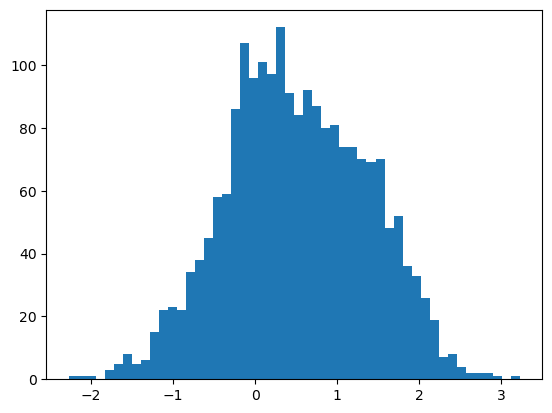

In [5]:

# histogram
plt.hist(df_f["log_Corr_increased"].dropna(), bins=50)
plt.show()


In [6]:
model_og = smf.mixedlm("log_Corr_increased ~ Topic*Timeframe + Topic*political_cluster_2020", #+ Timeframe*political_cluster_2020
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    ) 

model_og1 = smf.mixedlm("log_Corr_increased ~ Topic*Timeframe *political_cluster_2020", #+ Timeframe*political_cluster_2020
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    ) 

model_og2 = smf.mixedlm("log_Corr_increased ~ Topic*Timeframe + Topic*political_cluster_2020+ Timeframe*political_cluster_2020",
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    )
eval_model(model_og, df_f)
eval_model(model_og1, df_f)
eval_model(model_og2, df_f)

R2: 0.43549609479285045
MSE: 0.4133099037806067

Significant coefficients (corrected p <= 0.1
Topic[T.Preventive Measures]: coef: 0.483, Std. Error: 0.122, P-value: 0.000
Topic[T.Quarantine]: coef: 0.734, Std. Error: 0.122, P-value: 0.000
Topic[T.Testing]: coef: -0.439, Std. Error: 0.122, P-value: 0.000
Topic[T.Virus]: coef: 0.505, Std. Error: 0.122, P-value: 0.000
Topic[T.Quarantine]:political_cluster_2020[T.Republican]: coef: -0.243, Std. Error: 0.127, P-value: 0.055
Topic[T.Preventive Measures]:Timeframe: coef: -0.085, Std. Error: 0.031, P-value: 0.007
Topic[T.Quarantine]:Timeframe: coef: -0.065, Std. Error: 0.031, P-value: 0.037
Topic[T.Vaccination]:Timeframe: coef: 0.201, Std. Error: 0.031, P-value: 0.000
Topic[T.Virus]:Timeframe: coef: 0.087, Std. Error: 0.031, P-value: 0.005
R2: 0.43687574520347494
MSE: 0.41229977227716424

Significant coefficients (corrected p <= 0.1
Topic[T.Preventive Measures]: coef: 0.496, Std. Error: 0.166, P-value: 0.003
Topic[T.Quarantine]: coef: 0.664, S

# Population Density

In [7]:
from shapely import wkt
import geopandas as gpd
df_f['geometry_x'] = df_f['geometry_y'].apply(lambda x: wkt.loads(x))

gdf = gpd.GeoDataFrame(df_f, geometry='geometry_x')
gdf = gdf.set_crs("EPSG:4326")  # assign CRS
gdf_projected = gdf.to_crs("EPSG:3857")   # transform

gdf_projected['area_km2'] = gdf_projected['geometry_x'].area / 1e6  # convert m² to km²
gdf_projected['pop_density'] = gdf_projected['population_x'] / gdf_projected['area_km2']
df_f['pop_density'] = gdf_projected['pop_density']

(array([1974.,   42.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          42.]),
 array([1.22038021e+00, 2.39622563e+02, 4.78024745e+02, 7.16426927e+02,
        9.54829110e+02, 1.19323129e+03, 1.43163347e+03, 1.67003566e+03,
        1.90843784e+03, 2.14684002e+03, 2.38524220e+03]),
 <BarContainer object of 10 artists>)

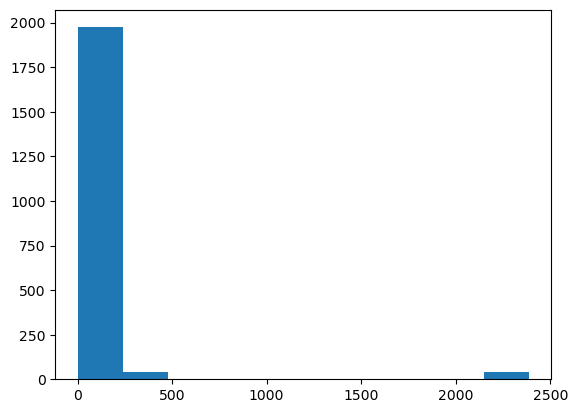

In [8]:
import matplotlib.pyplot as plt
plt.hist(df_f['pop_density'])

In [9]:

model_pop = smf.mixedlm("log_Corr_increased ~ Topic*Timeframe + Topic*pop_density", #+ Timeframe*political_cluster_2020
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    ) 
eval_model(model_pop, df_f)

R2: 0.4347982812179798
MSE: 0.4138208183355393

Significant coefficients (corrected p <= 0.1
Topic[T.Preventive Measures]: coef: 0.494, Std. Error: 0.096, P-value: 0.000
Topic[T.Quarantine]: coef: 0.621, Std. Error: 0.096, P-value: 0.000
Topic[T.Testing]: coef: -0.408, Std. Error: 0.096, P-value: 0.000
Topic[T.Virus]: coef: 0.504, Std. Error: 0.096, P-value: 0.000
Topic[T.Preventive Measures]:Timeframe: coef: -0.085, Std. Error: 0.031, P-value: 0.007
Topic[T.Quarantine]:Timeframe: coef: -0.065, Std. Error: 0.031, P-value: 0.037
Topic[T.Vaccination]:Timeframe: coef: 0.201, Std. Error: 0.031, P-value: 0.000
Topic[T.Virus]:Timeframe: coef: 0.087, Std. Error: 0.031, P-value: 0.005


# Vaccination data

In [10]:
import pandas as pd
import geopandas as gpd
df = pd.read_csv(r"../../../data/utils/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv")# Source: https://catalog.data.gov/dataset/covid-19-vaccinations-in-the-united-statesjurisdiction-07bc5
custom_timeframes = ['2020-06-08', '2020-09-29', '2021-04-07', '2021-07-13', '2021-11-22', '2022-04-25']
states_shp = gpd.read_file(r'../../../data/utils/US_states_data/county_data.shp')
df.Date = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.sort_values(by=['Date','Location'], inplace=True)

In [11]:
df

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Novavax,Distributed_Unk_Manuf,Dist_Per_100K,...,Dist_Bivalent_PFR,Dist_Bivalent_MOD,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct
38483,2020-12-13,51,AS,3900,0,0,0,NaN,0,7003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38487,2020-12-13,51,GU,3900,0,0,0,NaN,0,2353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38482,2020-12-13,51,LTC,0,0,0,0,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38485,2020-12-13,51,MP,4875,0,0,0,NaN,0,8570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38486,2020-12-13,51,US,13650,0,0,0,NaN,0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,2023-05-10,19,VT,2588940,74200,831220,1244690,3500.0,0,414902,...,322130.0,113200.0,213211.0,35.8,206110.0,37.4,196740.0,38.6,86640.0,69.3
172,2023-05-10,19,WA,25606455,777800,7783800,12807915,41600.0,0,336268,...,2944300.0,1251040.0,1977241.0,27.6,1907183.0,29.3,1828199.0,30.7,720971.0,59.6
139,2023-05-10,19,WI,16474175,457200,5144600,8183105,22900.0,0,282943,...,1815090.0,851280.0,1330586.0,24.2,1298038.0,26.0,1251270.0,27.5,600688.0,59.1
493,2023-05-10,19,WV,5515855,172600,1967420,2696125,10700.0,0,307779,...,419570.0,249440.0,210085.0,12.4,208143.0,13.4,204380.0,14.3,115583.0,31.5


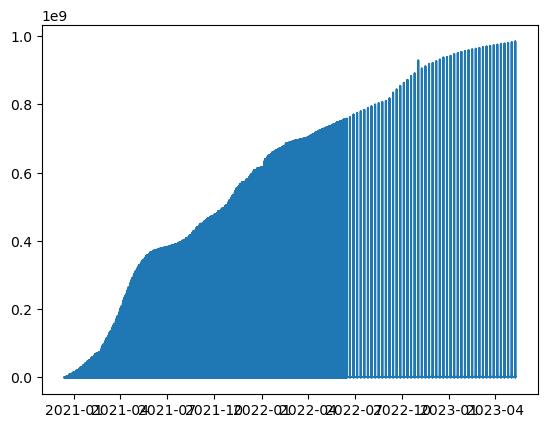

In [12]:
from matplotlib import pyplot as plt
df.index = df.Date

plt.plot(df['Distributed'], label='Locations with Vaccines Distributed')

In [13]:
states_dict = dict(zip(states_shp['state'],(states_shp['state_full']).str.lower()))
states_dict_r = dict(zip((states_shp['state_full']).str.lower(),states_shp['state']))
states = df_f.state_x.unique()
states_f = [states_dict_r[el] for el in states]

custom_timeframes = ['2020-06-08', '2020-09-29', '2021-04-07', '2021-07-13', '2021-11-22', '2022-04-25']
df_f['distributed'] = -1
state = []
for s in states_f:
    vaxs = []
    val= 0
    for in_t in range(len(custom_timeframes)):
        distr = df[(df['Location']==s) & (df['Date'] < custom_timeframes[in_t])]['Distributed'].values
        if len(distr) == 0:
            distr2 = 0
            val = 0

        else:
            distr2 = distr[-1].item()-val
            val = distr[-1].item()

        df_f.loc[(df_f['state_shor'] == s.lower()) & (df_f['Timeframe'] == in_t), 'distributed'] = distr2

    
        vaxs.append(distr)
    state.append(vaxs)

    df_f['distributed_norm'] = df_f['distributed'] / df_f['population_x']


# custom_timeframes = ['2020-06-08', '2020-09-29', '2021-04-07', '2021-07-13', '2021-11-22', '2022-04-25']
# df_f['distributed'] = -1
# state = []
# for s in states_f:
#     vaxs = []
#     for in_t in range(len(custom_timeframes)):
#         df_s = df[df['Location']==s].copy()
#         df_s['Distributed'] = df_s['Distributed'].diff()
#         distr = df_s[(df_s['Date'] < custom_timeframes[in_t])]['Distributed'].values
#         # if len(distr) == 0:
#         #     distr = 0
#         # else:
#         #     distr = distr[-1].item()
#         distr = sum(distr) if len(distr) > 0 else 0

#         df_f.loc[(df_f['state_shor'] == s.lower()) & (df_f['Timeframe'] == in_t), 'distributed'] = distr

    
#         vaxs.append(distr)
#     state.append(vaxs)

(array([686.,   0.,  14.,  70., 133., 252., 399., 238., 210.,  56.]),
 array([0.        , 0.08208158, 0.16416315, 0.24624473, 0.3283263 ,
        0.41040788, 0.49248945, 0.57457103, 0.6566526 , 0.73873418,
        0.82081575]),
 <BarContainer object of 10 artists>)

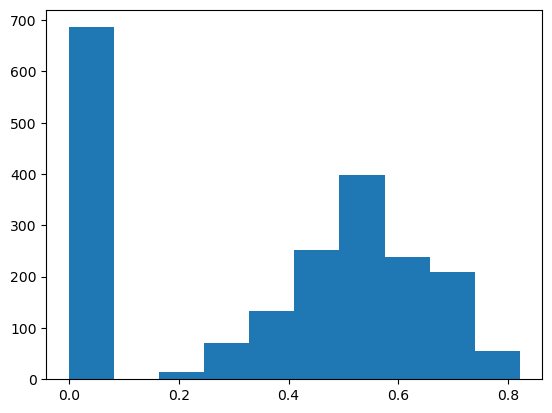

In [14]:
plt.hist(df_f['distributed_norm'])

In [15]:

model_og = smf.mixedlm("Corr_increased ~ Topic*Timeframe + Topic*political_cluster_2020", #+ Timeframe*political_cluster_2020
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    ) 
model_og2 = smf.mixedlm("Corr_increased ~ Topic*Timeframe + Topic*political_cluster_2020+ Timeframe*political_cluster_2020",
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    ) 
eval_model(model_og, df_f)

R2: 0.14884216540191053
MSE: 0.6231878282414235

Significant coefficients (corrected p <= 0.1
Intercept: coef: 0.603, Std. Error: 0.080, P-value: 0.000
Topic[T.Preventive Measures]: coef: 0.105, Std. Error: 0.026, P-value: 0.000
Topic[T.Quarantine]: coef: 0.148, Std. Error: 0.026, P-value: 0.000
Topic[T.Testing]: coef: -0.082, Std. Error: 0.026, P-value: 0.001
Topic[T.Virus]: coef: 0.102, Std. Error: 0.026, P-value: 0.000
Topic[T.Quarantine]:political_cluster_2020[T.Republican]: coef: -0.052, Std. Error: 0.027, P-value: 0.055
Topic[T.Preventive Measures]:Timeframe: coef: -0.018, Std. Error: 0.007, P-value: 0.006
Topic[T.Vaccination]:Timeframe: coef: 0.041, Std. Error: 0.007, P-value: 0.000
Topic[T.Virus]:Timeframe: coef: 0.021, Std. Error: 0.007, P-value: 0.002


In [16]:

model_vac = smf.mixedlm("log_Corr_increased ~ Topic*Timeframe + Topic*distributed_norm", #+ Timeframe*political_cluster_2020
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    ) 
eval_model(model_vac, df_f, p_value=1)

R2: 0.4508491497223611
MSE: 0.4020689369828202

Significant coefficients (corrected p <= 1
Intercept: coef: 0.611, Std. Error: 0.410, P-value: 0.136
Topic[T.Preventive Measures]: coef: 0.429, Std. Error: 0.096, P-value: 0.000
Topic[T.Quarantine]: coef: 0.494, Std. Error: 0.096, P-value: 0.000
Topic[T.Symptoms]: coef: 0.012, Std. Error: 0.096, P-value: 0.902
Topic[T.Testing]: coef: -0.503, Std. Error: 0.096, P-value: 0.000
Topic[T.Vaccination]: coef: -0.192, Std. Error: 0.096, P-value: 0.046
Topic[T.Virus]: coef: 0.467, Std. Error: 0.096, P-value: 0.000
Timeframe: coef: -0.066, Std. Error: 0.138, P-value: 0.629
Topic[T.Preventive Measures]:Timeframe: coef: -0.174, Std. Error: 0.041, P-value: 0.000
Topic[T.Quarantine]:Timeframe: coef: -0.226, Std. Error: 0.041, P-value: 0.000
Topic[T.Symptoms]:Timeframe: coef: 0.013, Std. Error: 0.041, P-value: 0.761
Topic[T.Testing]:Timeframe: coef: -0.051, Std. Error: 0.041, P-value: 0.219
Topic[T.Vaccination]:Timeframe: coef: 0.038, Std. Error: 0.041,

# Education

In [17]:
# url = "https://raw.githubusercontent.com/zief0002/rustic-penguin/main/data/state-education.csv"
# state_educ_income = pd.read_csv(url)

# # Display the first few rows
# print(state_educ_income.head())


# # Load the Excel sheet into a DataFrame


In [18]:
df_edu = pd.read_excel(r"../../../data/utils/Education2023 (1).xlsx", dtype=str)

In [19]:
#source: https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data
df_edu = pd.read_excel(r"../../../data/utils\Education2023 (1).xlsx", dtype=str)
df_edu['Area name'] = df_edu['Area name'].str.lower()
df_edu_f= df_edu[df_edu['Area name'].isin(list(df_f.state_x.unique()))]


edu_col = "Some college or associate degree, 2019-23"#"Bachelor's degree or higher, 2019-23" #High school graduate (or equivalency), 2019-23 #Less than high school graduate, 2019-23
df_f['edu'] = -1
for i, row in df_f.iterrows():
    state = row['state_x'].lower()
    if state in df_edu_f['Area name'].values:
        edu_value = df_edu_f[df_edu_f['Area name'] == state][edu_col].values[0]
        df_f.at[i, 'edu'] = float(edu_value)
df_f['edu_norm'] = df_f['edu']/df_f['population_x']

(array([ 42.,   0.,   0.,  42., 210., 294., 462., 588., 252., 168.]),
 array([0.10134906, 0.11605714, 0.13076522, 0.14547329, 0.16018137,
        0.17488945, 0.18959752, 0.2043056 , 0.21901368, 0.23372175,
        0.24842983]),
 <BarContainer object of 10 artists>)

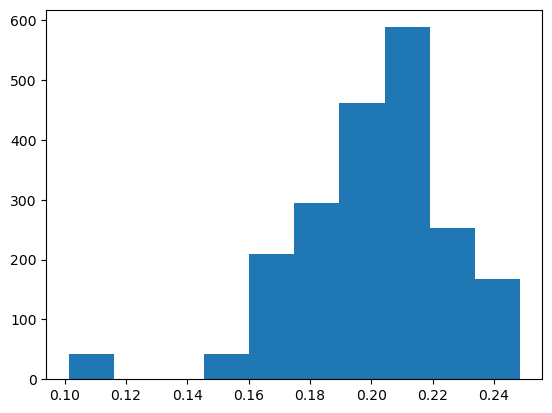

In [20]:
plt.hist(df_f['edu_norm'])

In [21]:
model_edu = smf.mixedlm("log_Corr_increased ~ Topic*Timeframe + Topic*edu_norm", #+ Timeframe*political_cluster_2020
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    ) 
eval_model(model_edu, df_f)


R2: 0.43344795603927977
MSE: 0.4148094789356395

Significant coefficients (corrected p <= 0.1
Topic[T.Quarantine]: coef: 0.999, Std. Error: 0.432, P-value: 0.021
Topic[T.Preventive Measures]:Timeframe: coef: -0.085, Std. Error: 0.031, P-value: 0.007
Topic[T.Quarantine]:Timeframe: coef: -0.065, Std. Error: 0.031, P-value: 0.037
Topic[T.Vaccination]:Timeframe: coef: 0.201, Std. Error: 0.031, P-value: 0.000
Topic[T.Virus]:Timeframe: coef: 0.087, Std. Error: 0.031, P-value: 0.005


# comapre models with differnet predictors

In [22]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_rel

# Step 1: Fit all models
model_og_fit = model_og.fit()
model_pop_fit = model_pop.fit()
model_vac_fit = model_vac.fit()
model_edu_fit = model_edu.fit()

# Step 2: Define actual values
y_true = df_f["Corr_increased"]

# Step 3: Create a function to compute comparison stats
def compare_model_errors(base_model_fit, compare_model_fit, y_true, name=""):
    # Get fitted values
    y_pred_base = base_model_fit.fittedvalues
    y_pred_compare = compare_model_fit.fittedvalues
    
    # MSEs
    mse_base = mean_squared_error(y_true, y_pred_base)
    mse_compare = mean_squared_error(y_true, y_pred_compare)
    
    # Squared residuals
    resid_base = (y_true - y_pred_base) 
    resid_compare = (y_true - y_pred_compare) 
    
    # plt.hist(y_pred_compare)
    # plt.hist(resid_base)
    # plt.show()

    resid_base = (y_true - y_pred_base) ** 2
    resid_compare = (y_true - y_pred_compare) ** 2

    # plt.hist(y_pred_compare)
    # plt.hist(resid_base)
    # plt.show()

    # Paired t-test
    t_stat, p_val = ttest_rel(resid_base, resid_compare)
    
    # Output
    print(f"\nModel: {name}")
    print(f"MSE Base Model (OG):     {mse_base:.5f}")
    print(f"MSE Compared Model:      {mse_compare:.5f}")
    print(f"T-statistic:             {t_stat:.4f}")
    print(f"P-value:                 {p_val:.4f}")
    
    return {
        "Model": name,
        "MSE_OG": mse_base,
        "MSE_Model": mse_compare,
        "T_stat": t_stat,
        "P_val": p_val
    }

# Step 4: Run comparisons
results = []
results.append(compare_model_errors(model_og_fit, model_pop_fit, y_true, name="POP"))
results.append(compare_model_errors(model_og_fit, model_vac_fit, y_true, name="VAC"))
results.append(compare_model_errors(model_og_fit, model_edu_fit, y_true, name="EDU"))

# Step 5: Optional – Put results into a DataFrame
results_df = pd.DataFrame(results)



Model: POP
MSE Base Model (OG):     0.01851
MSE Compared Model:      0.22643
T-statistic:             -32.4548
P-value:                 0.0000

Model: VAC
MSE Base Model (OG):     0.01851
MSE Compared Model:      0.23291
T-statistic:             -30.5780
P-value:                 0.0000

Model: EDU
MSE Base Model (OG):     0.01851
MSE Compared Model:      0.22594
T-statistic:             -32.3832
P-value:                 0.0000


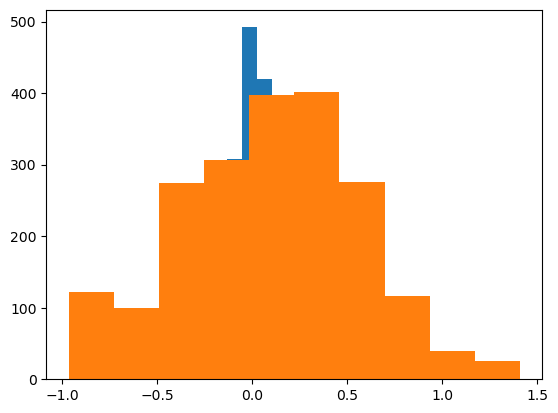


Model: POP
MSE Base Model (OG):     0.01851
MSE Compared Model:      0.22643
Wilcoxon statistic:      794234.0000
P-value (Wilcoxon):      0.0000
T-statistic:             -9.9099
P-value:                 0.0000


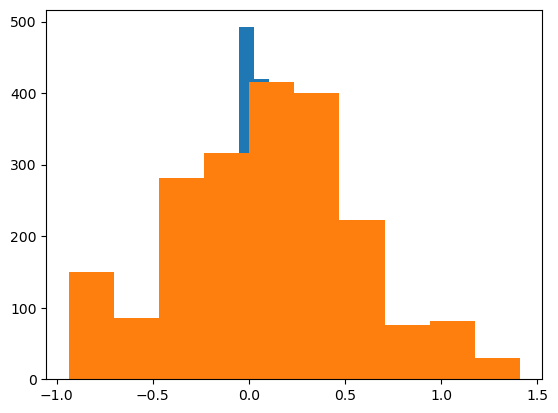


Model: VAC
MSE Base Model (OG):     0.01851
MSE Compared Model:      0.23291
Wilcoxon statistic:      804961.0000
P-value (Wilcoxon):      0.0000
T-statistic:             -9.6296
P-value:                 0.0000


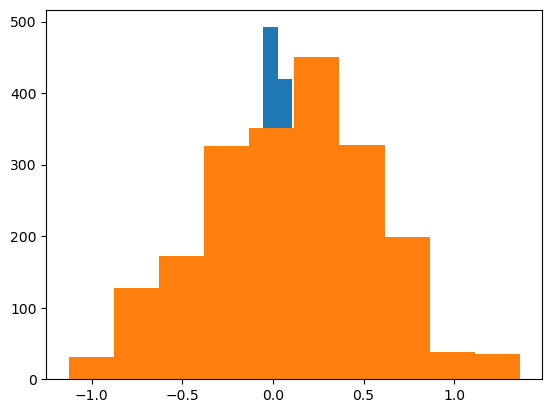


Model: EDU
MSE Base Model (OG):     0.01851
MSE Compared Model:      0.22594
Wilcoxon statistic:      796514.0000
P-value (Wilcoxon):      0.0000
T-statistic:             -9.9345
P-value:                 0.0000


In [34]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel


# Step 1: Fit all models
model_og_fit = model_og.fit()
model_pop_fit = model_pop.fit()
model_vac_fit = model_vac.fit()
model_edu_fit = model_edu.fit()

# Step 2: Define actual values
y_true = df_f["Corr_increased"]

# Step 3: Create a function to compute comparison stats
def compare_model_errors(base_model_fit, compare_model_fit, y_true, name=""):
    # Get fitted values
    y_pred_base = base_model_fit.fittedvalues
    y_pred_compare = compare_model_fit.fittedvalues
    
    # MSEs
    mse_base = mean_squared_error(y_true, y_pred_base)
    mse_compare = mean_squared_error(y_true, y_pred_compare)
    
    # Residuals (NOT squared)
    resid_base = (y_true - y_pred_base) 
    resid_compare = (y_true - y_pred_compare) 
    
    plt.hist(resid_base)
    plt.hist(resid_compare)
    plt.show()

    # resid_base = (y_true - y_pred_base) ** 2
    # resid_compare = (y_true - y_pred_compare) ** 2

    # plt.hist(y_pred_compare)
    # plt.hist(resid_base)
    # plt.show()

    # Wilcoxon signed-rank test (non-parametric)
    w_stat, p_val_w = wilcoxon(resid_base, resid_compare)
    t_stat, p_val = ttest_rel(resid_base, resid_compare)

    # Output
    print(f"\nModel: {name}")
    print(f"MSE Base Model (OG):     {mse_base:.5f}")
    print(f"MSE Compared Model:      {mse_compare:.5f}")
    print(f"Wilcoxon statistic:      {w_stat:.4f}")
    print(f"P-value (Wilcoxon):      {p_val_w:.4f}")
    print(f"T-statistic:             {t_stat:.4f}")
    print(f"P-value:                 {p_val:.4f}")
    
    return {
        "Model": name,
        "MSE_OG": mse_base,
        "MSE_Model": mse_compare,
        "Wilcoxon_stat": w_stat,
        "P_val": p_val_w
    }

# Step 4: Run comparisons
results = []
results.append(compare_model_errors(model_og_fit, model_pop_fit, y_true, name="POP"))
results.append(compare_model_errors(model_og_fit, model_vac_fit, y_true, name="VAC"))
results.append(compare_model_errors(model_og_fit, model_edu_fit, y_true, name="EDU"))

# Step 5: Optional – Put results into a DataFrame
results_df = pd.DataFrame(results)


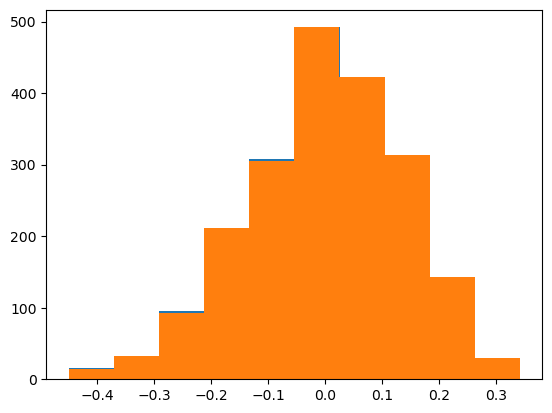


Model: EDU
MSE Base Model (OG):     0.01851
MSE Compared Model:      0.01851
Wilcoxon statistic:      1039437.0000
P-value (Wilcoxon):      0.4600
T-statistic:             -0.0000
P-value:                 1.0000


In [35]:
model_og2_fit = model_og2.fit()

results.append(compare_model_errors(model_og_fit, model_og2_fit, y_true, name="EDU"))


# Cross Validation

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Average Cross-Validation MSE: 0.6043 ± 0.0344
Average Cross-Validation R²: 0.1589 ± 0.0559
Average Cross-Validation RMSE: 0.7771 ± 0.0222
Average Cross-Validation MAE: 0.6244 ± 0.0183


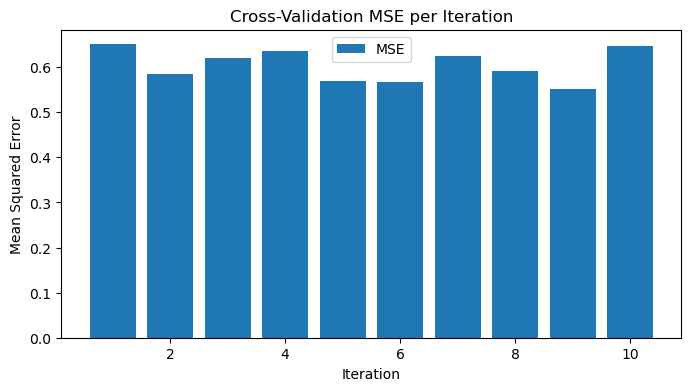

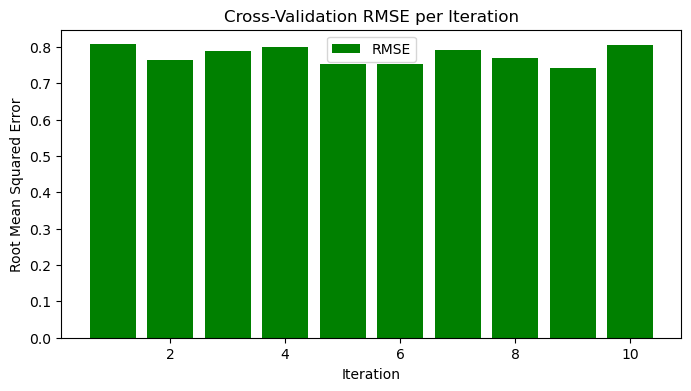

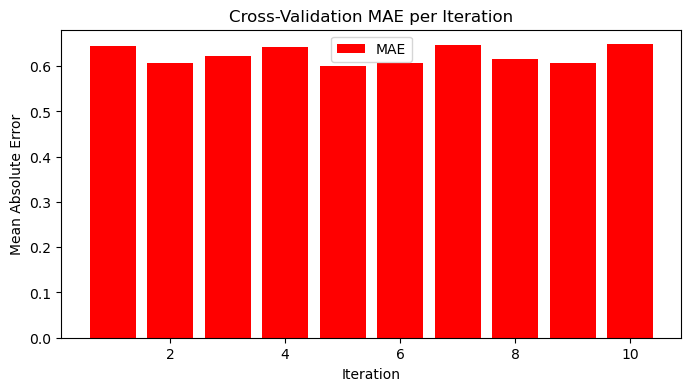

In [36]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Prepare data
X = df_f.copy()
y = X["log_Corr_increased"]

# Store metrics
mse_scores = []
r2_scores = []
rmse_scores = []
mae_scores = []

# Number of iterations for cross-validation
n_iterations = 10

# Unique timeframes
timeframes = X["Timeframe"].unique()

# Cross-validation loop
for iteration in range(n_iterations):
    print(f"Iteration {iteration + 1}/{n_iterations}")
    
    # Lists to store concatenated training and testing data for this iteration
    train_data_combined = []
    test_data_combined = []

    # Loop through each timeframe
    for timeframe in timeframes:
        # Select data for the current timeframe
        timeframe_data = X[X["Timeframe"] == timeframe]
        
        # Randomly select 10% for testing in this iteration
        test_data = timeframe_data.sample(frac=0.1, random_state=36 + iteration)  # Using a different random seed for each iteration
        train_data = timeframe_data.drop(test_data.index)
        
        # Append the train and test data to the combined lists
        train_data_combined.append(train_data)
        test_data_combined.append(test_data)

    # Concatenate all training data (across all timeframes)
    train_data_combined = pd.concat(train_data_combined)
    test_data_combined = pd.concat(test_data_combined)

    # Fit mixed model on the combined training data
    model_cross = smf.mixedlm("log_Corr_increased ~ Topic*Timeframe + Topic*political_cluster_2020", 
                              data=train_data_combined, 
                              groups=train_data_combined["Timeframe"])
    result_cross = model_cross.fit()

    # Predict on the combined test set
    y_pred_cross = result_cross.predict(test_data_combined)

    # Compute metrics for this iteration
    mse = mean_squared_error(test_data_combined["log_Corr_increased"], y_pred_cross)
    r2 = r2_score(test_data_combined["log_Corr_increased"], y_pred_cross)
    rmse = np.sqrt(mse)  # RMSE is the square root of MSE
    mae = mean_absolute_error(test_data_combined["log_Corr_increased"], y_pred_cross)

    # Append the metrics to their respective lists
    mse_scores.append(mse)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# Print results
print(f"Average Cross-Validation MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"Average Cross-Validation R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Average Cross-Validation RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Average Cross-Validation MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

# Visualizing results
plt.figure(figsize=(8, 4))
plt.bar(range(1, n_iterations + 1), mse_scores, label="MSE")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.title("Cross-Validation MSE per Iteration")
plt.legend()
plt.show()

# 'plt.figure(figsize=(8, 4))
# plt.bar(range(1, n_iterations + 1), r2_scores, label="R²", color="orange")
# plt.xlabel("Iteration")
# plt.ylabel("R² Score")
# plt.title("Cross-Validation R² per Iteration")
# plt.legend()
# plt.show()'

plt.figure(figsize=(8, 4))
plt.bar(range(1, n_iterations + 1), rmse_scores, label="RMSE", color="green")
plt.xlabel("Iteration")
plt.ylabel("Root Mean Squared Error")
plt.title("Cross-Validation RMSE per Iteration")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, n_iterations + 1), mae_scores, label="MAE", color="red")
plt.xlabel("Iteration")
plt.ylabel("Mean Absolute Error")
plt.title("Cross-Validation MAE per Iteration")
plt.legend()
plt.show()


In [37]:
df_f['log_Corr_increased'].describe()
# (range: min -2.271299, max 3.224985)

count    2058.000000
mean        0.510384
std         0.855874
min        -2.271299
25%        -0.094207
50%         0.469903
75%         1.148756
max         3.224985
Name: log_Corr_increased, dtype: float64

In [38]:
from scipy.stats import shapiro, ttest_1samp, wilcoxon
import seaborn as sns

# Check normality
stat, p_shapiro = shapiro(mse_scores)
print(f"Shapiro-Wilk Test for normality: p = {p_shapiro:.4f}")

# If normal:
if p_shapiro > 0.05:
    # Use one-sample t-test to check if MSEs deviate significantly from mean
    t_stat, p_ttest = ttest_1samp(mse_scores, np.mean(mse_scores))
    print(f"One-sample t-test: p = {p_ttest:.4f}")
else:
    # Use non-parametric test
    w_stat, p_wilcox = wilcoxon(mse_scores - np.mean(mse_scores))
    print(f"Wilcoxon signed-rank test: p = {p_wilcox:.4f}")


Shapiro-Wilk Test for normality: p = 0.3836
One-sample t-test: p = 1.0000


In [39]:
 # Use non-parametric test
# rmse
w_stat, p_wilcox = wilcoxon(rmse_scores - np.mean(rmse_scores))
print(f"Wilcoxon signed-rank test: p = {p_wilcox:.4f}")

Wilcoxon signed-rank test: p = 1.0000


In [40]:
 # Use non-parametric test
# mae_scores
w_stat, p_wilcox = wilcoxon(mae_scores - np.mean(mae_scores))
print(f"Wilcoxon signed-rank test: p = {p_wilcox:.4f}")

Wilcoxon signed-rank test: p = 0.8457


In [41]:
# Coefficient of Variation
cv_mse = np.std(mae_scores) / np.mean(mae_scores)
print(f"Coefficient of Variation (MSE): {cv_mse:.4f}")


Coefficient of Variation (MSE): 0.0293


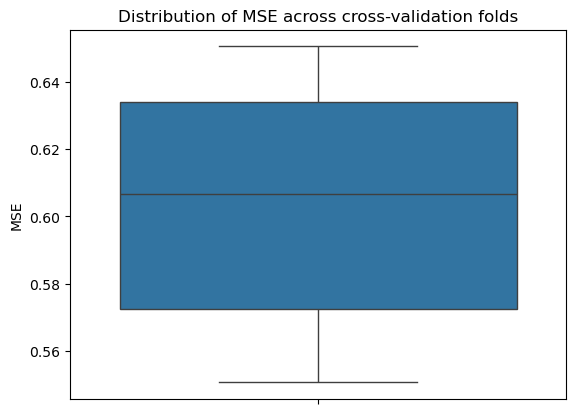

In [42]:
sns.boxplot(data=mse_scores)
plt.title("Distribution of MSE across cross-validation folds")
plt.ylabel("MSE")
plt.show()


# Investigate the Residuals for the entire the model: QQ-Plots and Residuals vs fitted Values

In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Function to apply Fisher transformation
def fisher_transform(x):
    return 0.5 * np.log((1 + x) / (1 - x)) # -1,+1 to -inf,+inf

def log_transform(x):
    return np.log(x / (1 - x)) # -1,+1 to -inf,+inf


# Apply the Fisher transformation to the specified column
df_f['fisher_Corr_increased'] = df_f['Corr_increased'].apply(fisher_transform)
df_f['log_Corr_increased'] = df_f['Corr_increased'].apply(log_transform)

#
# MAIN MODEL USED IN THE PAPER
#
# Compare to R code
# Corr Mixed effects Model Corr_increased ~ Topic * political_cluster_2020 + Timeframe", groups=df["Timeframe"], re_formula="~Timeframe+political_cluster_2020"
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Exclude the COVID-19 Baseline-Topic: since otherwise the treatments are not independet 


# Fit the mixed effects model
model = smf.mixedlm("log_Corr_increased ~ Topic*Timeframe + Topic*political_cluster_2020", #+ Timeframe*political_cluster_2020
                    data=df_f, 
                    groups=df_f["Timeframe"],# Random intercept for Timeframe
                    #re_formula="~Timeframe"  # Random slope: Random slopes allow the relationship between the predictor(s) and the outcome to vary across the different groups
                    )  
result = model.fit( )

# Print the original summary of the model
#print(result.summary())
y_pred = result.fittedvalues
r2_score_var=r2_score(df_f["log_Corr_increased"], y_pred)
#print(f'R2: {r2_score_var}')
mse = mean_squared_error(df_f["log_Corr_increased"], y_pred)
#print(f"MSE: {mse}")

# Bonferroni correction (Sidak correction) for multiple comparisons
# Get the p-values from the model
pvalues = result.pvalues


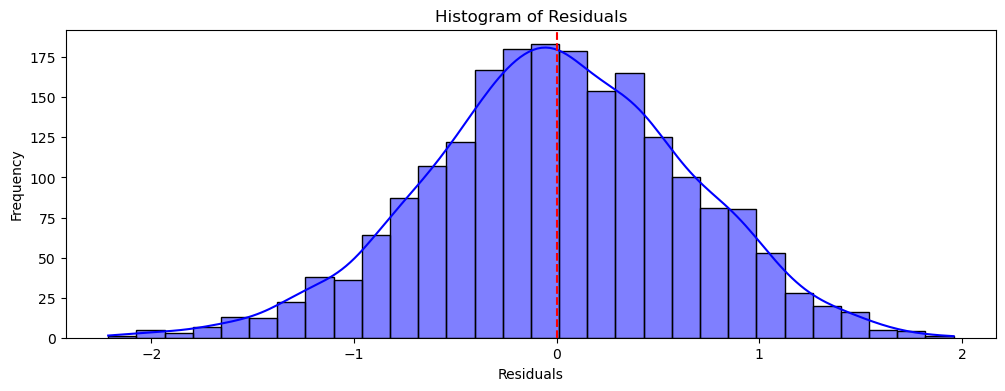

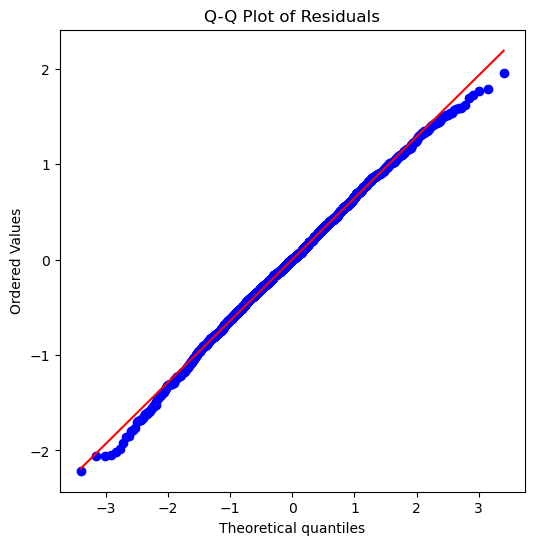

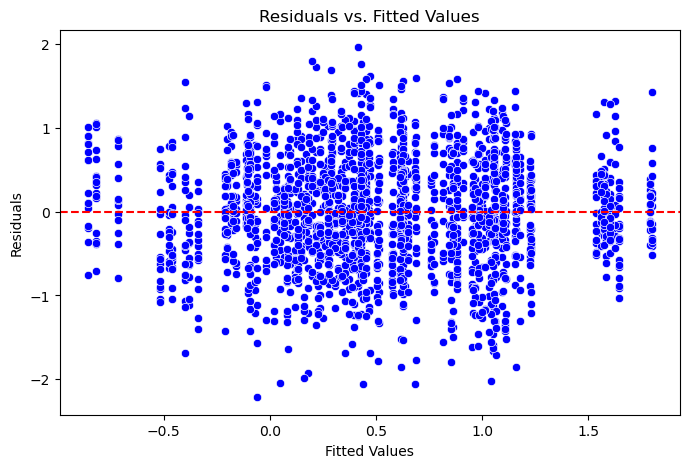

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Extract residuals
residuals = result.resid  # Raw residuals
fitted_values = result.fittedvalues  # Predicted values

# 1. Histogram of residuals
plt.figure(figsize=(12, 4))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# 2. Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# 3. Residuals vs. Fitted Values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_values, y=residuals, color="blue")
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()
